# Week of 2025.07.30

## Goal of this week:
- [x] Create clean visulizations that show the current state of the infrasound work.
- [x] Coordinate meeting with Fred + Mario + Eric to discuss the current state of things and figure out what needs to further be worked on.
- [x] Get Fred's lightpath data to verify methods for calculating pressure at observer
- [x] Put together slide show. 
- [x] Get access from to `/oak/stanford/groups/edunham`


## Things to change
- [x] Plot mach numbers 
- [x] Color bar of atmosphere + plot heat 
- [x] Add atmosphere temperature plot.
- [x] Reduce stem to maybe 10 m
- [x] time series of flank of volcano. 

## Notes 
- public wifi can block ssh access. 

## Sherlock notes
- Jupyter notebooks can be run via [interactive sessions](https://ondemand.sherlock.stanford.edu/pun/sys/dashboard/batch_connect/sessions)
- In theory there is a way to ssh onto sherlock via VS code like [this](https://www.sherlock.stanford.edu/docs/storage/data-transfer/#sshfs). That appeals to me because it means I could run a simulation and visualize locally on vs code but have all the data live on sherlock. 
- To run a job with dedicated resources do something like: `sh_dev -t 24` which launches an interactive shell. 
- After running in some challenges with the sherlock time limit, I increased the time limit and changed the shell script to look like:
    ```
    #!/usr/bin/bash
    #BATCH --job-name=quail
    #SBATCH --time=60:00:00
    #SBATCH --ntasks=1
    #SBATCH --cpus-per-task=16
    #SBATCH --mem=32GB
    #SBATCH -p serc
    module load python/3.12.1
    # User defineed variables
    export PATH=$PATH:/oak/stanford/groups/edunham/paxtonsc/quail_volcano/src

    cd $OAK/paxtonsc/volcano-sims/2025_07_21_eruption_sim/

    quail conduit.py
    ```

This script I called `run_quail.sbatch` and I started the batch jobs with the call `sbatch run_quail.sbatch` and subsequently observed the state of the jobs with `squeue --me`.

Although as of this writing my job has not yet gotten to the time when it runs, I believe I can watch the progress with `ssh sh02-01n49`. 


## Questions 
- [x] Once you start a job on sherlock how the heck do you check its progress? Turns out a log is generated in the same folder as the bash script. 

In [7]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure, animate_melt_atmosphere_combination
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 10
C0 = 320 # m/s at 5000m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.0 Velocity & Pressure at outlet of various runs

In [8]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_no_atm, p_tung_no_atm, slip_tung_no_atm, u_tung_no_atm, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

file_name = "tungurahua_atm_1m"
folder_name = "2025_07_21_eruption_sim"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_1m, p_tung_atm_1m, slip_tung_atm_1m, u_tung_atm_1m, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
file_name = "tungurahua_atm_1m"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
t_tung_atm_1m_1d, p_tung_atm_1m_1d, slip_tung_atm_1m_1d, u_tung_atm_1m_1d, _ = get_quantities_at_conduit_exit(
    solver_func, iterations=100, compute_temp=True, conduit_index=-1
)

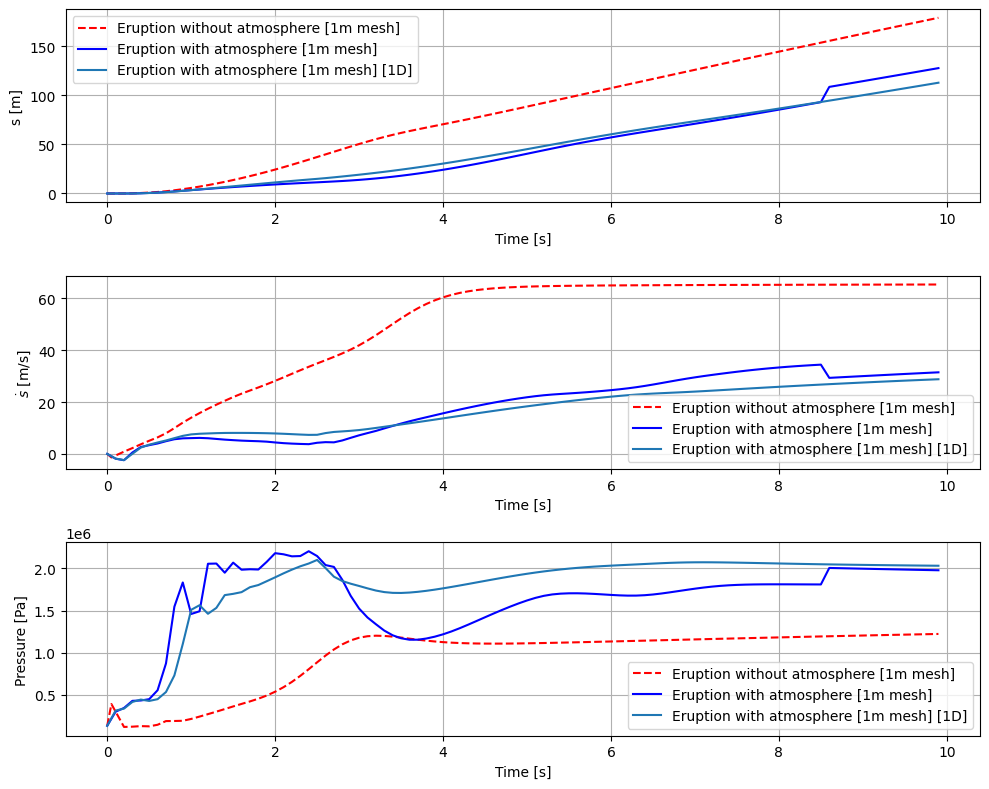

In [9]:
# Plot results
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(t_tung_no_atm, slip_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, slip_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m_1d, slip_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_tung_no_atm, u_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, u_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m_1d, u_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel(r"$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_tung_no_atm, p_tung_no_atm, "r--", label="Eruption without atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m, p_tung_atm_1m, "b-", label="Eruption with atmosphere [1m mesh]")
plt.plot(t_tung_atm_1m_1d, p_tung_atm_1m_1d, label="Eruption with atmosphere [1m mesh] [1D]")
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/slip_pressure_slip_dot.png", dpi=300)
plt.tight_layout()
plt.show()

## 1.0 Eruption paired with **1D** atmosphere

In [10]:
folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
melt_file_name = "tungurahua_atm_01m"
atmosphere_file_name = "vertical_atmosphere_02_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=8,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.13,
    min_pressure=0.07,
    max_velocity=50,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=150,
    min_slip=0,
    max_speed_of_sound=100
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/1d_atmosphere_combination.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())


## 2.0 Eruption paired with **2D** atmosphere

### 2.1 Melt

In [11]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=1,
    viscosity_index=1,
    wall_friction_index=5,
    max_velocity=20,
    max_slip=60,
    max_tau=1.5,
    max_pressure=25,
    max_speed_of_sound=2000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_mach=2.0,
    max_viscosity=2,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/conduit_flow_connected_2D_atmosphere.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())


### 2.2 Atmosphere
- Time elapsed for me to run this simulation locally: 10hr?

In [12]:
from helper_code.atmosphere_animate import atmosphere_2d_animate

folder_name = "2025_07_21_eruption_sim"
file_name = "test_infrasound_v1_atm1"
iterations = 80

ani = atmosphere_2d_animate(
    iterations=iterations,
    d_iter=4,
    folder=folder_name,
    file_name=file_name
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/2d_atmosphere.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())

### 2.3 Time Series Pressure Data


In [13]:
import matplotlib.tri as tri
from helper_code.infrasound import *

folder_name = "2025_07_21_eruption_sim"
file_name = "test_infrasound_v1_atm1"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
iterations = 80

solver_0 = solver_func(0)

triangulation = tri.Triangulation(solver_0.mesh.node_coords[...,0],
                  solver_0.mesh.node_coords[...,1], 
                  triangles=solver_0.mesh.elem_to_node_IDs)

trifinder = triangulation.get_trifinder()

p_20 = infrasound.get_p_series(20, 0, solver_func, trifinder, iterations=iterations, p0=1e5)
p_50 = infrasound.get_p_series(50, 0, solver_func, trifinder, iterations=iterations, p0=1e5)
p_80 = infrasound.get_p_series(80, 0, solver_func, trifinder, iterations=iterations, p0=1e5)

Element ID for point (20, 0): 5085
Element ID for point (50, 0): 6102
Element ID for point (80, 0): 6478


/Users/paxton/git/volcano_sims/notebooks/helper_code/infrasound.py:102: UserWarning: In TriCubicInterpolator initialization, PCG sparse solver did not converge after 1000 iterations. `geom` approximation is used instead of `min_E`
  U_target = np.array([tri.CubicTriInterpolator(


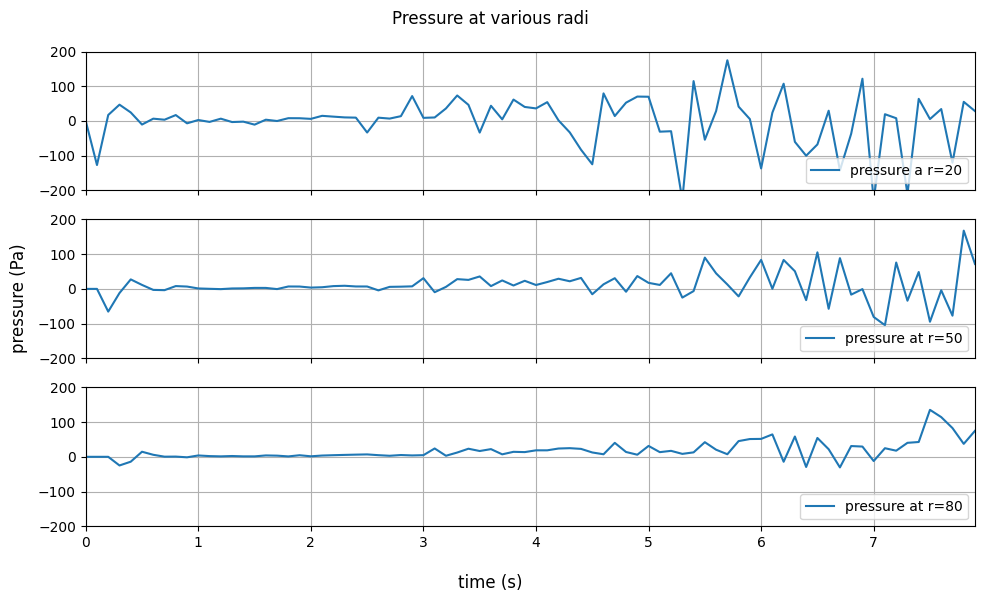

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
t_end = solver_func(iterations-1).time
t = np.linspace(0, t_end, len(p_20))
C0 = 320

axes[0].plot(t, p_20, label="pressure a r=20")
axes[1].plot(t, p_50, label="pressure at r=50")
axes[2].plot(t, p_80, label="pressure at r=80")


for i, ax in enumerate(axes):
    ax.legend(loc='lower right')
    ax.grid(True)
    ax.set_ylim(-200, 200)  
    ax.set_xlim(0, t_end)

fig.suptitle("Pressure at various radi")
fig.supylabel("pressure (Pa)")
fig.supxlabel("time (s)")

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/pressure_atm_time_series.png", dpi=300)
plt.tight_layout()
plt.show()

## 3.0 Light hill stress tensor

### 3.1 Accoustic pressure calculate as volume intergral

I am calculating the volume integral over the half-cylindrical region bounded by $r < 80 $ and $y > -80$ and $y<80$. 

As we can see in the above graphics, the value of the double divergence of the  lighthill stress tensor falls off outside those bounds. 

The equation we solve below is:

$$
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial^2 T_{ij}}{\partial y_i \partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
$$

To solve for pressure as a time series, we can just iterate over the integral for all time steps. We need only calculate the value of $\frac{\partial^2 T_{ij}}{\partial y_i \partial y_j}$ when $t - \frac{|x-y|}{c_0}$ is greater than 0 and less than the end of the simulation. 

- [ ] The $4 \pi$ in the denominator is technically incorrect for our geometry. 

My implementation can be found [here](http://github.com/paxtonsc/volcano-sims/blob/main/notebooks/helper_code/lighthill.py#L78). Validation for that implementation can be found in [section 3.1 here](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.05.20.experiments.html). 

In [15]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

iterations = 80

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("2025_07_21_eruption_sim", f"test_infrasound_v1_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 125, 200)
base_y = np.linspace(-125, 125, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,iterations,1)

In [16]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

            # I believe this is the correct calculation for order 1
			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + solver.state_coeffs[ie,1,:] * ref_coords_loc[0] + solver.state_coeffs[ie,2,:] * ref_coords_loc[1])


In [17]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, solver_from_2D(1, iterations-1).time, T_interp.shape[0])

In [18]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [19]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [20]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [21]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

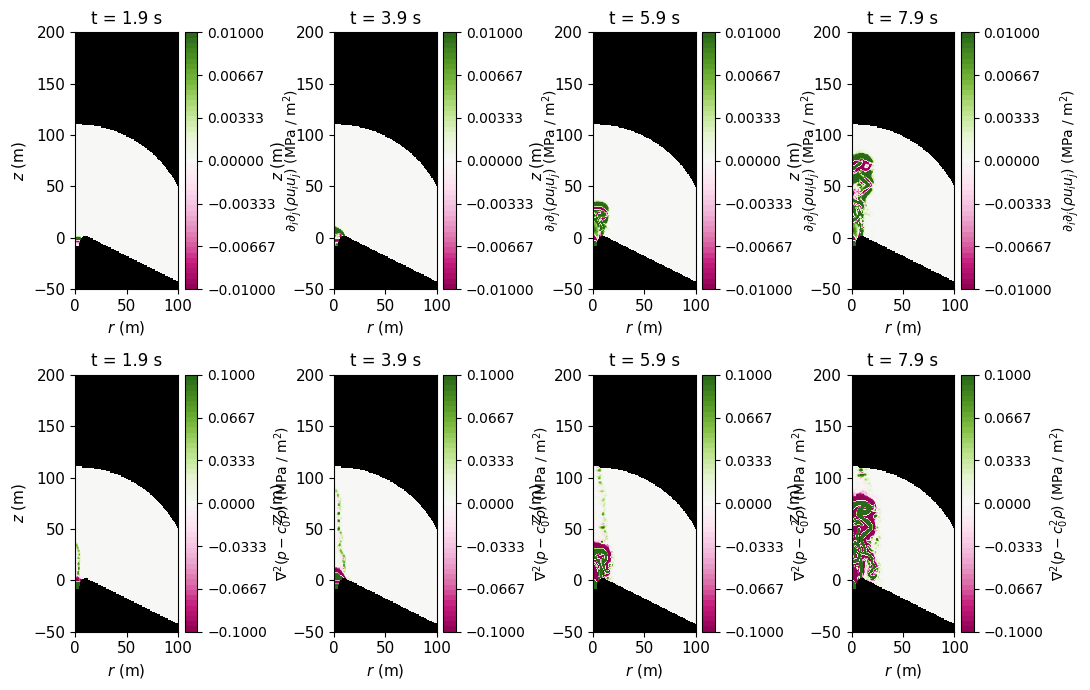

In [22]:
import matplotlib
fig, ax = plt.subplots(2, 4, figsize=(10.5,7))

levels = np.linspace(-1e4, 1e4, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [19, 39, 59, 79]

for i, t_ind in enumerate(t_indices):
  ax[0,i].set_facecolor("black")
  cf = ax[0,i].contourf(int_x, int_y, np.clip(dijTij_inertial[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[0,i].set_xlim(0, 100)
  ax[0,i].set_ylim(-50, 200)
  ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel("$r$ (m)")
  ax[0,i].set_ylabel("$z$ (m)")
  curr_ax = ax[0,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[0,i].set_title(f"t = {round(t_range[t_ind],2)} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

# fig.tight_layout()
  
# fig, ax = plt.subplots(1, 3, figsize=(8.5,3.5))

levels = np.linspace(-1e5, 1e5, 50) / 1e6
# t_indices = [3, 9, 36, 72]

for i, t_ind in enumerate(t_indices):
  ax[1,i].set_facecolor("black")
  cf = ax[1,i].contourf(int_x, int_y, np.clip(dijTij_nonlinear[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[1,i].set_xlim(0, 100)
  ax[1,i].set_ylim(-50, 200)
  ax[1,i].set_aspect('equal')
  ax[1,i].set_xlabel("$r$ (m)")
  ax[1,i].set_ylabel("$z$ (m)")
  curr_ax = ax[1,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[1,i].set_title(f"t = {round(t_range[t_ind],2)} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

fig.tight_layout()
plt.draw()
plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/lighthill_tensor_double_divergence.png')

In [23]:
import helper_code.lighthill as lighthill

source = dijTij_inertial + dijTij_nonlinear

print(source.shape)

x_obs = (50, -25, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-60, 60, 60)
Y = np.linspace(0, 60, 30)
Z = np.linspace(-60, 60, 60)

points = (t_range, int_y[:,0], int_x[0])

pressure_obs = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, int_x[0][-1], c0)

(80, 197, 197)
DV size is 8.558777204330914
X size is 60, Y size is 30, Z size is 60, t_range size is 80, file_index_list size is 80, x_obs size is 3, points size is 3
Number of contributions: 8265716
r average: 87.74447906706447
source value average: nan


<function matplotlib.pyplot.show(close=None, block=None)>

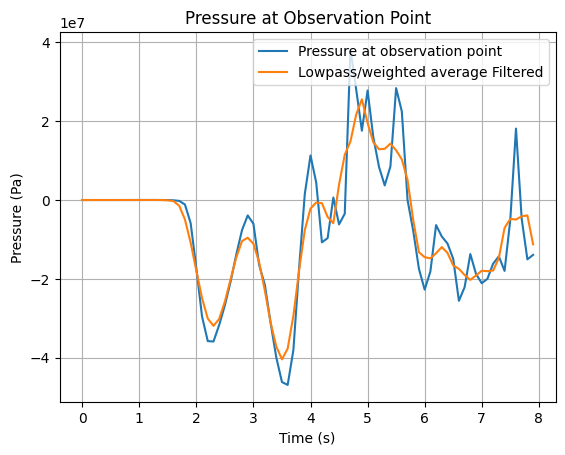

In [24]:
plt.plot(t_range, pressure_obs, label="Pressure at observation point")
plt.plot(t_range, lighthill.lowpass_weighted_average(pressure_obs, 2), label="Lowpass/weighted average Filtered")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/lighthill_pressure_at_observation_point.png", dpi=300)

plt.show

### 3.2 Surface integral approach


Eric suggested I solved this problem as a surface integral. Doing so would allow us to remove one spatial dimension at the expense of slightly more complicated math. 

Previously, we had expressed the pressure as the following integral.

$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial}{\partial y_i} \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
\end{align}
$$

Applying the divergence theorm, we are able to rewrite this volume integral as a surface intgral. 


$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_S \frac{1}{|x - y|}  \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) \cdot \hat{n} dy^2
\end{align}
$$

Let's integrate over the sphere with a radius $a=100m$. Let's review a couple aspects of spherical coordinates. 

$$
\begin{align}
dS =& a^2 \sin \phi d \phi d \theta \\
x =& a \sin \phi \cos \theta \\
y =& a \sin \phi \sin \theta \\
z =& a \cos \phi
\end{align}
$$

So we should be able to rewrite the surface integral as follows: 

$$
p'(x, t) = \frac{1}{4 \pi} \int_0^{\pi/3} \int_0^{2\pi}  \frac{1}{|x - y|} \frac{\partial T_{ij}}{\partial y_j} n_j a^2 \sin \phi d \phi d \theta
$$

My implementation can be found [here](https://github.com/paxtonsc/volcano-sims/blob/main/notebooks/helper_code/lighthill.py#L79).

In [25]:
Nt, Nx, Ny = mg_p.shape

# Central differences using np.diff (second difference)
d_p_dx = np.diff(mg_p, n=2, axis=1) / (2 * dx[0, 0])
d_p_dy = np.diff(mg_p, n=2, axis=2) / (2 * dy[0, 0])
d_rho_dx = np.diff(mg_rho, n=2, axis=1) / (2 * dx[0, 0])
d_rho_dy = np.diff(mg_rho, n=2, axis=2) / (2 * dy[0, 0])
    
# Pad arrays to restore original shape (Nx, Ny)
diTij_nonlinear = np.zeros((2, Nt, Nx, Ny))

d_c0_dx0 = np.diff(mg_c0, n=2, axis=0) / (2 * dx[0, 0])
d_c0_dx1 = np.diff(mg_c0, n=2, axis=1) / (2 * dy[0, 0])
diTij_nonlinear[0, :, 1:-1, :] = d_p_dx - mg_c0[1:-1, :]**2 * d_rho_dx - 2 * mg_c0[1:-1, :] * mg_rho[:, 1:-1, :] * d_c0_dx0
diTij_nonlinear[1, :, :, 1:-1] = d_p_dy - mg_c0[:, 1:-1]**2 * d_rho_dy - 2 * mg_c0[:, 1:-1] * mg_rho[:, :, 1:-1] * d_c0_dx1

diTij_nonlinear.shape

(2, 80, 200, 200)

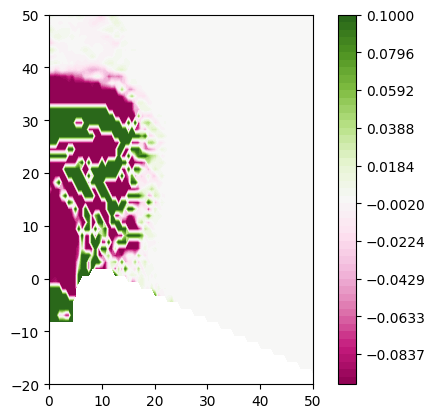

In [26]:

t_ind=60
plt.contourf(mg_x, mg_y, np.clip(diTij_nonlinear[0,t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
plt.xlim(0, 50)
plt.ylim(-20, 50)
plt.gca().set_aspect('equal')  # Set equal aspect ratio
plt.colorbar()

In [27]:
points = (range(2), t_range, mg_y[:,0], mg_x[0])

pressure_from_surface = np.zeros(len(file_index_list))
x_obs = (50, -25, 0)

for i, time_idx in enumerate(file_index_list):
    pressure_from_surface[i] = lighthill.calculate_surface_integral(diTij_nonlinear, 10, i, t_range, x_obs, c0, points, N_theta=80, N_phi=80)

    if i % 10 == 0: 
        print(f"Completed step of index {i}")

Completed step of index 0


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_96156/3011410418.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pressure_from_surface[i] = lighthill.calculate_surface_integral(diTij_nonlinear, 10, i, t_range, x_obs, c0, points, N_theta=80, N_phi=80)


Completed step of index 10
Completed step of index 20
Completed step of index 30
Completed step of index 40
Completed step of index 50
Completed step of index 60
Completed step of index 70


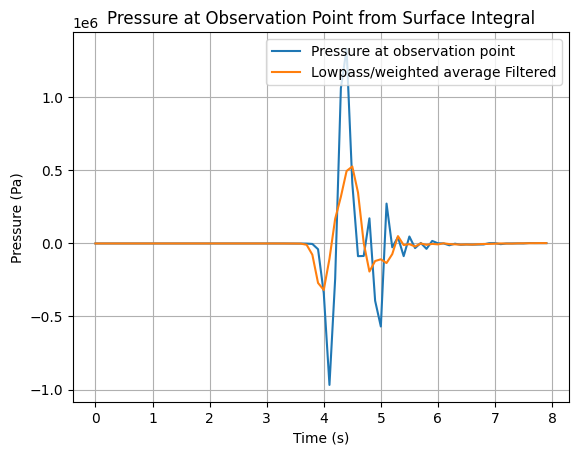

In [28]:
plt.plot(t_range, pressure_from_surface, label="Pressure at observation point")
plt.plot(t_range, lighthill.lowpass_weighted_average(pressure_from_surface, 2), label="Lowpass/weighted average Filtered")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point from Surface Integral")
plt.grid(True)
plt.legend()


plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/lighthill_pressure_from_surface_integral.png", dpi=300)

plt.show()

## 4.0 Apply light hill theory to Fred's .pkl files. 

The crux here was figuring out to use Sherlock. Here are a couple notes on some things I found out. 

The most straightforward way to access sherlock is via ssh. The downside, is it is tricky to run things like jupyter notebooks when ssh'ed onto the sherlock cluster. The recommended way to run a jupyter notebook on sherlock was to use the [Sherlock Ondemand service](https://ondemand.sherlock.stanford.edu/pun/sys/dashboard/batch_connect/sessions). I initially disliked this approach because it means I am doing all of my work on a browser (rather than a vs code terminal). 

One workaround was to use SSHFS which allowed me to mount a link to a sherlock directory on my local machine. I ran:

```
mkdir ~/sherlock_home
sshfs paxtonsc@dtn.sherlock.stanford.edu:/scratch/groups/edunham ~/sherlock_home
```

In theory I should now be able to access Fred's pkl files from my local jupyter notebook. Let's try to see if that works. 

In [29]:
# First, navigate to the sherlock mount point 

import os

os.chdir("/Users/paxton/git/volcano_sims/fred_data")

print(os.getcwd())
print(os.listdir())

# Load compressed npz archive
# The archive contains the field "time" and "state_coeffs"
#   archive["time"] is an np.array with size (n_timesteps)
#   archive["state_coeffs"] is an np.array with size (n_timesteps, n_elems, n_basis, n_states)
# The field "state_coeffs" contains the solver.state_coeffs variables for all
# the output files, combined into one array.

# Example below (loading multiple at a time may use a lot of memory):
archive = np.load(f"refblastH4_atm1.npz")

/Users/paxton/git/volcano_sims/fred_data
['refblastH4_atm2_0.pkl', 'refblastH4_atm1.npz', 'test_data.npz', 'refblastH4_atm2.npz', 'refblastH4_atm3.npz', 'refblastH4_atm1_0.pkl', 'refblastH4_atm3_0.pkl']


In [60]:
def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("fred_data", f"refblastH4_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 300, 200)
base_y = np.linspace(-125, 300, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,archive["time"].shape[0],10)

print(file_index_list.size)

361


In [ ]:
mg_y.shape

(200, 200)

: 

In [32]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		state_coeffs = archive["state_coeffs"][file_idx, ...]

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

            # I believe this is the correct calculation for order 1
			U_union[time_idx,write_idx,:] = (state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + state_coeffs[ie,1,:] * ref_coords_loc[0] + state_coeffs[ie,2,:] * ref_coords_loc[1])

In [33]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, archive["time"].max(), archive["time"].shape[0])

In [34]:
t_range.shape

(3601,)

In [35]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [36]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [37]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [38]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

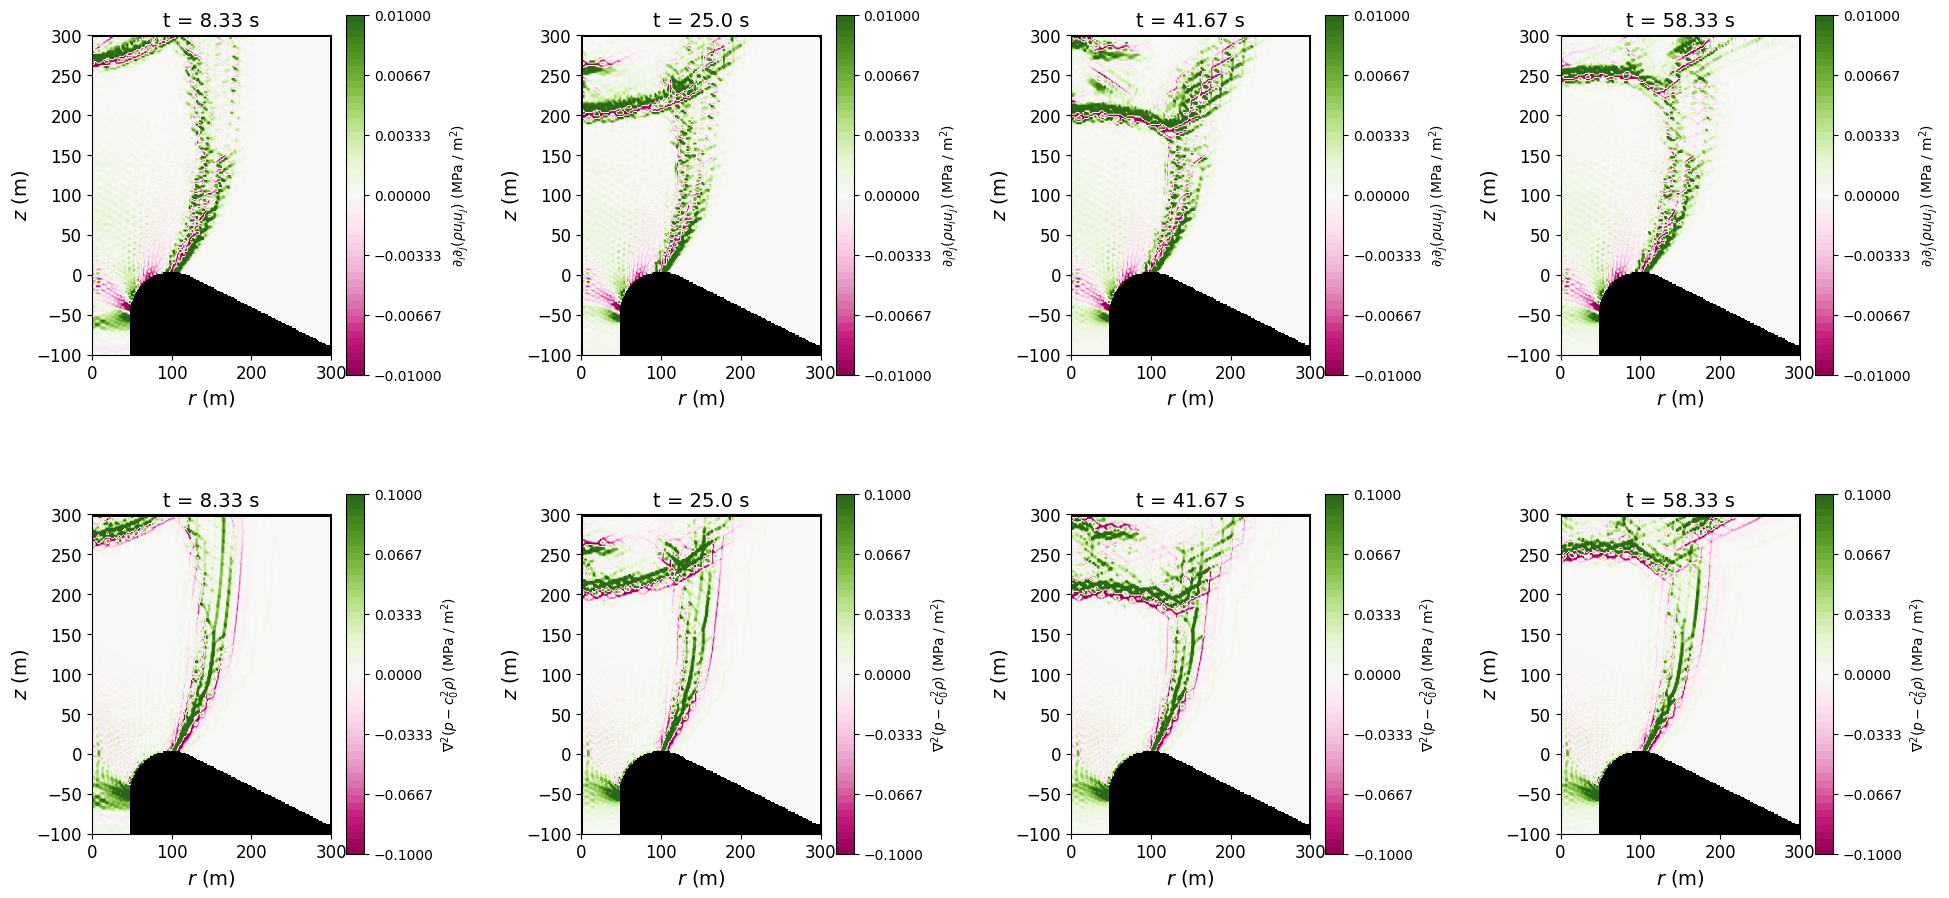

In [39]:
import matplotlib
import matplotlib.pyplot as plt

# Make figure much wider and taller to give each plot more space
fig, ax = plt.subplots(2, 4, figsize=(20, 10))  # was (10.5, 7)

levels = np.linspace(-1e4, 1e4, 50) / 1e6
t_indices = [50, 150, 250, 350]

for i, t_ind in enumerate(t_indices):
    ax[0, i].set_facecolor("black")
    cf = ax[0, i].contourf(
        int_x, int_y,
        np.clip(dijTij_inertial[t_ind, :, :] / 1e6, levels[0], levels[-1]),
        levels=levels, cmap=matplotlib.cm.PiYG
    )
    cb = fig.colorbar(
        cf, ax=ax[0, i],
        label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)"
    )
    ax[0, i].set_xlim(0, 300)
    ax[0, i].set_ylim(-100, 300)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlabel("$r$ (m)", fontsize=14)
    ax[0, i].set_ylabel("$z$ (m)", fontsize=14)
    ax[0, i].tick_params(labelsize=12)
    cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
    ax[0, i].set_title(f"t = {round(t_range[file_index_list[t_ind]], 2)} s", fontsize=14)

levels = np.linspace(-1e5, 1e5, 50) / 1e6

for i, t_ind in enumerate(t_indices):
    ax[1, i].set_facecolor("black")
    cf = ax[1, i].contourf(
        int_x, int_y,
        np.clip(dijTij_nonlinear[t_ind, :, :] / 1e6, levels[0], levels[-1]),
        levels=levels, cmap=matplotlib.cm.PiYG
    )
    cb = fig.colorbar(
        cf, ax=ax[1, i],
        label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)"
    )
    ax[1, i].set_xlim(0, 300)
    ax[1, i].set_ylim(-100, 300)
    ax[1, i].set_aspect('equal')
    ax[1, i].set_xlabel("$r$ (m)", fontsize=14)
    ax[1, i].set_ylabel("$z$ (m)", fontsize=14)
    ax[1, i].tick_params(labelsize=12)
    cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
    ax[1, i].set_title(f"t = {round(t_range[file_index_list[t_ind]], 2)} s", fontsize=14)

# Add more breathing room
fig.tight_layout(pad=3.0)
plt.draw()
plt.savefig(
    f'{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/lighthill_tensor_double_divergence_large.png',
    dpi=300
)


In [52]:
import helper_code.lighthill as lighthill
import numpy as np

indices = np.linspace(0, file_index_list.size-1, 50, dtype=int)

source = np.nan_to_num(dijTij_inertial + dijTij_nonlinear)[indices]

file_index_list_short = file_index_list[indices]

print(source.shape)

x_obs = (200, 0, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-250, 250, 50)
Y = np.linspace(-100, 250, 50)
Z = np.linspace(-250, 250, 50)

points = (t_range[file_index_list_short], int_y[:,0], int_x[0, :])

pressure_obs = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list_short, x_obs, points, source, t_range, int_x[0][-1], c0)

(50, 197, 197)
DV size is 743.7377283274836
X size is 50, Y size is 50, Z size is 50, t_range size is 3601, file_index_list size is 50, x_obs size is 3, points size is 3
Number of contributions: 5702768
r average: 288.6310866606649
source value average: 8.347330950153642


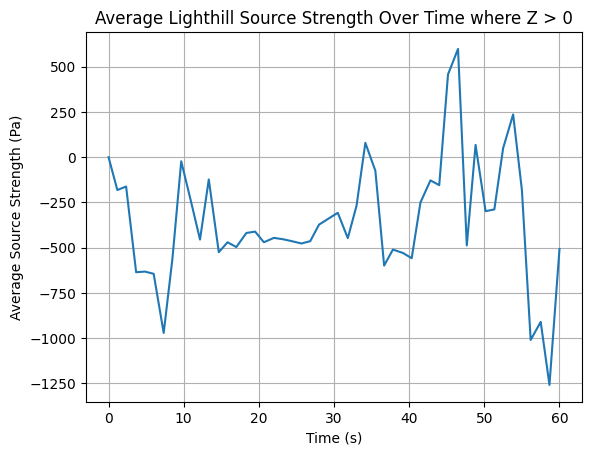

In [53]:
plt.plot(t_range[file_index_list_short], np.average(np.nan_to_num(source[:,57:,:]), axis=[1,2]))
plt.xlabel("Time (s)")
plt.ylabel("Average Source Strength (Pa)")
plt.title("Average Lighthill Source Strength Over Time where Z > 0")
plt.grid(True)



In [42]:
from scipy.interpolate import RegularGridInterpolator

interpolator =RegularGridInterpolator(points, source, method='linear', bounds_error=False, fill_value=0)



(100, 1000, 1000)
(100, 1000, 1000)


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_96156/680738486.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/paxton/git/volcano_sims/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


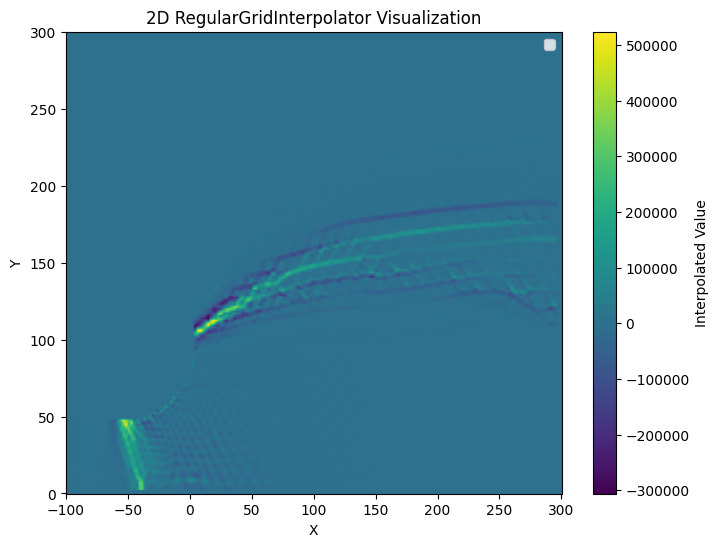

In [43]:
# Create a finer grid to visualize the interpolation
t_fine = np.linspace(0, t_range[-1], 100)
x_fine = np.linspace(-100, 300, 1000)
y_fine = np.linspace(0, 300, 1000)
T_fine, X_fine, Y_fine = np.meshgrid(t_fine, x_fine, y_fine, indexing='ij')

# Evaluate the interpolator
coords_fine = np.array([T_fine.ravel(), X_fine.ravel(), Y_fine.ravel()]).T
Z_fine = interpolator(coords_fine).reshape(X_fine.shape)

print(Z_fine.shape)
print(X_fine.shape)
# Plot the interpolation result
plt.figure(figsize=(8, 6))
plt.pcolormesh(X_fine[10], Y_fine[10], Z_fine[10], shading='auto', cmap='viridis')
plt.colorbar(label='Interpolated Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('2D RegularGridInterpolator Visualization')
plt.show()

(361, 200, 200)
x arg: 131
y arg: 57


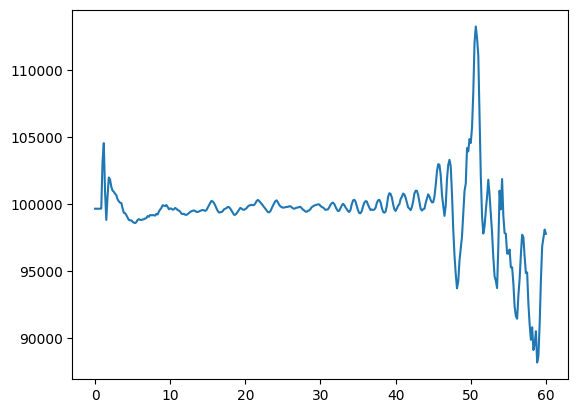

In [55]:
print(mg_p.shape)


print(f"x arg: {np.argmin(np.abs(int_x[0] - 200))}")
print(f"y arg: {np.argmin(np.abs(int_y[:,0] - 0))}")

x_idx = np.argmin(np.abs(int_x[0] - 2000))
y_idx = np.argmin(np.abs(int_y[:,0] - 0))


plt.plot(t_range[file_index_list], mg_p[:, y_idx, x_idx], label="Pressure at observation point")

<function matplotlib.pyplot.show(close=None, block=None)>

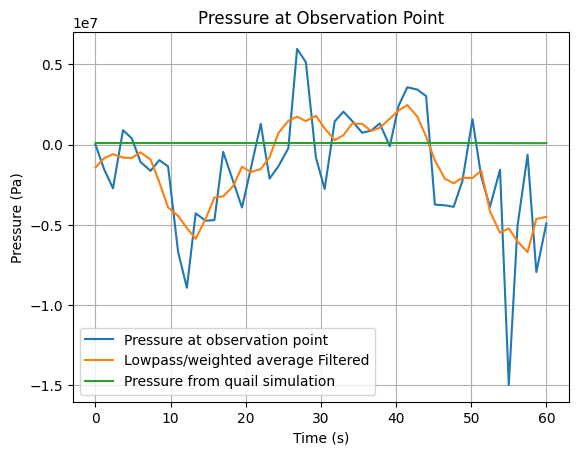

In [56]:
plt.plot(t_range[file_index_list_short], pressure_obs, label="Pressure at observation point")
plt.plot(t_range[file_index_list_short], lighthill.lowpass_weighted_average(pressure_obs, 2), label="Lowpass/weighted average Filtered")
plt.plot(t_range[file_index_list], mg_p[:, y_idx, x_idx], label="Pressure from quail simulation")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure at Observation Point")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/lighthill_pressure_at_observation_point.png", dpi=300)

plt.show

## A1. Review 2D Mesh

- The finest triangle mesh is of length 0.3m. That size expands to 3m per side outside of the vent tube. 

/Users/paxton/git/volcano_sims/fred_data

Points: (4897, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


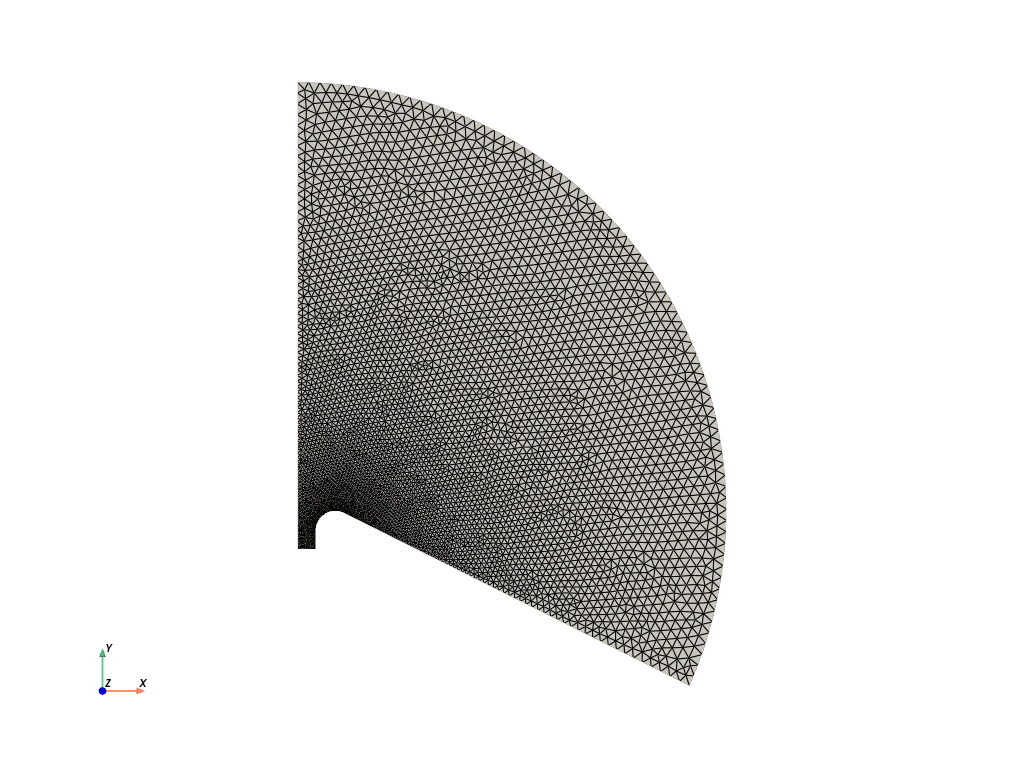

<Figure size 640x480 with 0 Axes>

In [46]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/tungurahuaA1.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()

plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/tungurahua_mesh.png', dpi=300)


## A2. Monopole source comparison 

Eric shared [notes](https://drive.google.com/file/d/1khrmHWfoOqrcBjE533TtZirvnp9IIAc3/view?usp=sharing) on 3D acoustics, from which I will use the relation 

$$
p(r,t) = \frac{\rho \dot{Q}(t-r/c)}{4 \pi r * (2/3)}
$$

See more in-depth notes in my notes from [many weeks ago](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.05.05.experiments.html).


In [47]:
folder_name = "2025_07_21_eruption_sim"
file_name = "tungurahua_no_atm_v0"
solver_func = get_local_solver_from_index_func(folder_name, file_name)

iters = 100
d_iters = 2


u_vec = []
t_vec = []
R = 5 # m

for i in range(0, iters, d_iters):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))
Q_dot_vec = np.pi * R**2 * a_vec # m^3/s^2

N = 100
pressure_array = np.zeros((len(t_vec), N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

X = np.linspace(x_low, x_upper, N)
Y = np.linspace(y_low, y_upper, N)

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array[0], extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=-50, vmax=100)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t_idx):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            if infrasound.point_in_volcano(x, y):
                pressure_array[int(t_idx), j, i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[int(t_idx), j, i] = infrasound.relative_pressure(t_idx, x, y, t_vec, Q_dot_vec)

    im.set_array(pressure_array[int(t_idx)])
    ax.set_title(f'Pressure Distribution at t={t_idx:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec), 
                    interval=100, blit=True)
ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/fred_presentation/monopole_eruption_model.mp4', writer='ffmpeg', fps=10)
display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

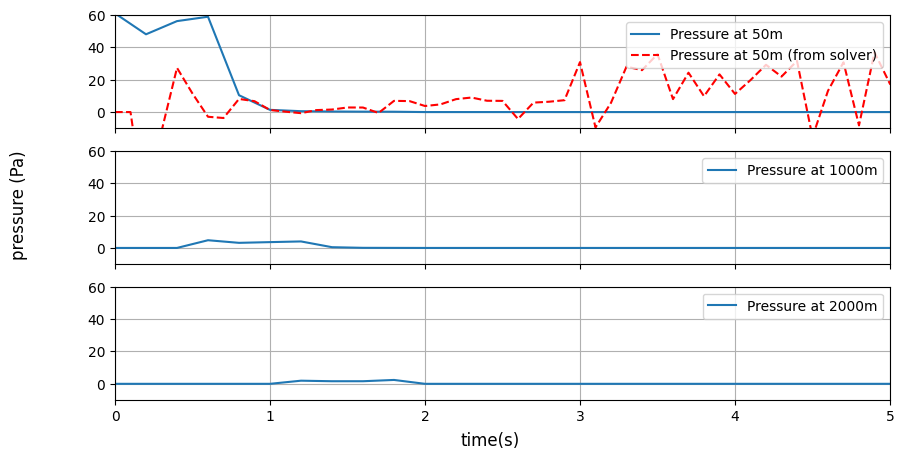

In [48]:
x_idx = np.argmin(np.abs(X - 2000))
y_idx = np.argmin(np.abs(Y))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)

axes[2].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 2000))], label="Pressure at 2000m")
axes[1].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 1000))], label="Pressure at 1000m")
axes[0].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 50))], label="Pressure at 50m")
axes[0].plot(t, p_50, "r--", label="Pressure at 50m (from solver)")

for i, ax in enumerate(axes):
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(-10, 60)  
    ax.set_xlim(0, 5)

fig.supxlabel("time(s)")
fig.supylabel("pressure (Pa)")

plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/fred_presentation/monopole_eruption_model_pressure_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## A3. Validate light hill volume integral with known source term

$$
G(\bf{x}, \bf{y}, t) = \frac{\delta(t - \frac{|\bf{x} - \bf{y}|}{c_0})}{4 \pi | \bf{x} - \bf{y}|}
$$
 
So the pressure at any given point can be expressed as 

$$
\begin{align}
p(\bf{x}, t) =& \int \int_V G(\bf{x}, \bf{y}, t - \tau) S(\bf{y}, \tau) d^3y d \tau \\

\end{align}
$$

In this case, because the source term is uniform across the volume $R < 100$ and $Y>0$ and $Y< 100$.

To find the max pressure we would expect, we write the equation:

$$
p_{max} = \frac{1}{4 \pi} \int_V \frac{1}{|x_{obs} - y|} dy 
$$

That can roughly be approximated as

$$
\begin{align}
p_{max} =& \frac{1}{4 \pi} \frac{V}{r_{avg}} \\
p_{max} =& \frac{1}{4 \pi} \frac{\pi * 100^2 * 200}{2300} \\
p_{max} =& 220 [Pa]
\end{align}
$$


In the below example, I show that numerically I arrive at a solution with a max pressure of about 190. 

In [49]:
import matplotlib 
n = len(t_range[file_index_list])  # Length of the vector
mu = n // 4  # Center of the pulse is 1/4 through the time series
sigma = 5  # Standard deviation (controls pulse width)

nx = len(int_x[0])
ny = len(int_y[:,0])

print(f"nx {nx} and ny {ny}")

x = np.arange(n)

# Compute Gaussian pulse
pulse = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

source_gaussian = np.zeros(dijTij_inertial.shape)

nan_mask = np.isnan(dijTij_inertial)

for i in range(nx):
    for j in range(ny):
        if int_y[j, 0] > 0 and int_y[j,0] < 200 and int_x[0,i] < 100:
            source_gaussian[:, j, i] = pulse

source_gaussian[nan_mask] = np.nan

clims = [-1, 1]

fig, ax = plt.subplots()

img = ax.imshow(source_gaussian[0], cmap=matplotlib.cm.PiYG, aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]])
plt.gca().invert_yaxis()
plt.colorbar(img)
ax.set_title('Uniform Gaussian Pulse')
ax.set_xlabel('radius (m)')
ax.set_ylabel('height (m)')


# Update function for animation
def update(i):
    img.set_array(source_gaussian[i])
    ax.set_title(f'Uniform Gaussian Pulse at t = {t_range[file_index_list[i]]:.2f} s')
    return [img]

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(len(t_range[file_index_list])), 
                    interval=50, blit=True)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/uniform_gaussian_pulse.mp4', writer='ffmpeg', fps=10, bitrate=1800)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

nx 197 and ny 197


In [50]:
X = np.linspace(-200, 100, 20)
Y = np.linspace(0, 200, 20)
Z = np.linspace(-100, 100, 20)

points = (t_range[file_index_list], int_y[:,0], int_x[0])

x_obs = (2000, -1000, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation

pressure_test = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source_gaussian, t_range, int_x[0][-1], c0)

DV size is 1749.5261699956259
X size is 20, Y size is 20, Z size is 20, t_range size is 3601, file_index_list size is 361, x_obs size is 3, points size is 3
Number of contributions: 2494650
r average: 2329.2715996538714
source value average: nan


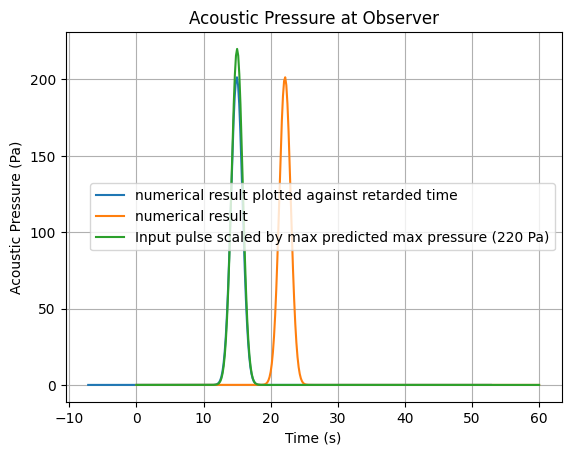

Max pressure 201.44228753425384


In [51]:
r_avg = 2300 #m
retarded_time = t_range[file_index_list] - r_avg/c0

# Plot acoustic pressure
plt.plot(retarded_time, pressure_test[:,], label="numerical result plotted against retarded time")
plt.plot(t_range[file_index_list], pressure_test[:,], label="numerical result")
plt.plot(t_range[file_index_list], pulse*220, label="Input pulse scaled by max predicted max pressure (220 Pa)")
plt.xlabel('Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Acoustic Pressure at Observer')
plt.grid(True)
plt.legend(loc='center right')

plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/pressure_verification.png')
plt.show()

plt.close()

print(f"Max pressure {max(pressure_test)}")

In [59]:
mg_v.shape

(361, 200, 200)